# Identifying Out-of-Tune Instruments in Multi-Instrument Mixes using VGGish Transfer Learning

**Team Members**: [Insert names]  
**Course**: CS8321 - Advanced Machine Learning and Neural Networks  
**University**: Southern Methodist University, Dallas  
**Semester**: Spring 2025

This project investigates whether a machine learning model can identify which instrument in a polyphonic audio mixture is out of tune. Using synthetic data derived from the NSynth dataset and pre-trained VGGish audio embeddings, we aim to build a robust classifier capable of detecting tuning irregularities in complex musical environments.

## Table of Contents

1. [Motivation & Research Questions](#motivation)
2. [Related Work](#related-work)
3. [Problem Statement & Hypothesis](#problem)
4. [Dataset Description & Preprocessing](#dataset)
5. [Transfer Learning: VGGish Embeddings](#transfer)
6. [Modeling](#modeling)
7. [Methodology](#methodology)
8. [Preliminary Analysis & Results](#results)
9. [Evaluation Metrics](#evaluation)
10. [Ethical Considerations](#ethics)
11. [Future Work](#future)
12. [References](#references)


## Motivation & Research Questions <a name="motivation"></a>


## Related Work <a name="related-work"></a>

## Problem Statement & Hypothesis <a name="problem"></a>

**Problem Statement**:  
Detect and localize which instrument in a multi-instrument audio mix is out of tune.

**Hypothesis**:  
We hypothesize that VGGish embeddings retain enough frequency-shift sensitivity to enable binary (in-tune vs. out-of-tune) and multi-class (instrument identification) classification, even when audio sources are blended.



## Dataset Description & Preprocessing <a name="dataset"></a>

We used the **NSynth-train** dataset from Activeloop’s DeepLake hub and applied the following steps:

- Randomly selected 3 instruments per mix (total 1000 samples).
- Applied pitch shift of ±1–2 semitones to one instrument per sample.
- Mixed audio clips to form polyphonic audio.
- Normalized and exported as `.wav` files.
- Saved instrument labels and pitch shift metadata in `labels.csv`.

In [ ]:
import os
import random
import librosa
import numpy as np
import soundfile as sf
import pandas as pd
from tqdm import tqdm
import deeplake

# Load NSynth from DeepLake
ds = deeplake.load("hub://activeloop/nsynth-train")

# Output folder
OUTPUT_PATH = "mixed_out_of_tune_samples"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Parameters
sample_rate = 16000
duration_sec = 4
pitch_shift_range = [-2, -1, 1, 2]  # in semitonesA
mix_size = 3
total_samples = 1000

# Memory-friendly pitch shift function
def simple_pitch_shift(y, semitones, sr):
    rate = 2 ** (semitones / 12)
    y_stretched = librosa.effects.time_stretch(y, rate=1 / rate)
    y_shifted = librosa.resample(y_stretched, orig_sr=sr, target_sr=sr)
    # Use keyword arguments to ensure compatibility
    return librosa.util.fix_length(data=y_shifted, size=len(y))

metadata = []

for i in tqdm(range(total_samples)):
    # Pick mix_size random samples
    chosen_samples = random.sample(list(ds), mix_size)
    out_of_tune_idx = random.randint(0, mix_size - 1)
    pitch_shift = random.choice(pitch_shift_range)

    # Initialize mixture once per outer iteration
    mixture = np.zeros((sample_rate * duration_sec,), dtype=np.float32)
    label = {}

    for idx, sample in enumerate(chosen_samples):
        # Get the audio array from the sample
        y = np.array(sample["audios"], dtype=np.float32)
        
        # Flatten to 1D if needed and fix the length to the specified duration
        if y.ndim > 1:
            y = y.flatten()
        y = librosa.util.fix_length(y, size=sample_rate * duration_sec)
        
        # Convert instrument value to string.
        # Here, instrument is stored as a tensor integer so we convert it.
        instrument_val = sample["instrument"].numpy()
        if instrument_val.ndim == 0:
            instrument_val = instrument_val.item()
        instrument_name = str(instrument_val)
        
        # Apply pitch shift to one sample and note the instrument
        if idx == out_of_tune_idx:
            y = simple_pitch_shift(y, pitch_shift, sample_rate)
            label['out_of_tune'] = instrument_name
        else:
            label.setdefault('in_tune', []).append(instrument_name)
        
        # Add the audio sample to the mixture
        mixture += y

    # Normalize the mixed audio
    mixture /= np.max(np.abs(mixture) + 1e-6)

    # Write the output file
    filename = f"mix_{i}.wav"
    sf.write(os.path.join(OUTPUT_PATH, filename), mixture, sample_rate)

    label['filename'] = filename
    metadata.append(label)

# Save metadata to CSV
df = pd.DataFrame(metadata)
df.to_csv(os.path.join(OUTPUT_PATH, "labels.csv"), index=False)

## Transfer Learning: VGGish Embeddings <a name="transfer"></a>

We leverage **VGGish**, a pretrained audio feature extractor developed by Google, based on the VGG architecture. It converts audio into 128-dimensional embeddings suitable for downstream tasks.

### Why VGGish?
- Trained on large-scale YouTube data
- Robust across audio types (speech, music, environmental sounds)
- Eliminates need for custom feature engineering

### Preprocessing for VGGish:
- Convert `.wav` to mono, 16kHz
- Slice or pad into 0.96s frames
- Extract VGGish embeddings per file for classifier input


In [4]:
# Transfer Learning using Spectrogram Images + EfficientNet

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# CONFIG
IMG_DIR     = "mixed_out_of_tune_samples_spectogram"
LABELS_CSV  = os.path.join(IMG_DIR, "labels.csv")
IMG_SIZE    = (224, 224)

# LOAD LABELS
df       = pd.read_csv(LABELS_CSV)
img_paths = [os.path.join(IMG_DIR, fn) for fn in df["spectrogram_filename"]]
labels    = df["out_of_tune"].astype(str).tolist()

# LOAD EfficientNetB0 FROM TENSORFLOW HUB
efficient_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"
)

def extract_embedding(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize(IMG_SIZE)
        img_array = np.array(img).astype(np.float32)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        img_tensor = np.expand_dims(img_array, axis=0)  # Add batch dim
        embedding = efficient_model.predict(img_tensor, verbose=0)
        return embedding.flatten()
    except Exception as e:
        print(f"Failed on {image_path}: {e}")
        return None

# EXTRACT FEATURES
X_embed = [extract_embedding(path) for path in tqdm(img_paths)]
X_embed = [x for x in X_embed if x is not None and not np.isnan(x).any()]
labels  = [label for x, label in zip(X_embed, labels) if x is not None and not np.isnan(x).any()]
X       = np.stack(X_embed)

# FILTER TO TOP 10 CLASSES WITH ≥ 2 SAMPLES
counts  = Counter(labels)
top10   = [lab for lab, _ in counts.most_common(10)]
filtered = [(x, lab) for x, lab in zip(X, labels) if lab in top10]
X, labels = zip(*filtered)

counts = Counter(labels)
keep   = [lab for lab, c in counts.items() if c >= 2]
mask   = [lab in keep for lab in labels]

X       = np.array(X)[mask]
labels  = np.array(labels)[mask]

print(f"Filtered down to {len(set(labels))} classes:", set(labels))
print(f"Remaining samples: {len(labels)}")

# ENCODE LABELS
le    = LabelEncoder()
y_enc = le.fit_transform(labels)
y_cat = to_categorical(y_enc)

# SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_enc, random_state=42
)

# BUILD MLP MODEL
model = Sequential([
    Dense(512, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax'),
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# TRAIN
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    verbose=1
)

# EVALUATE
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {acc:.4f}")

# SAVE MODEL + ENCODER
model.save("efficientnet_spectrogram_classifier.h5")

import joblib
joblib.dump(le, "label_encoder.joblib")


100%|██████████| 1000/1000 [01:35<00:00, 10.48it/s]

Filtered down to 10 classes: {'[56]', '[844]', '[427]', '[719]', '[264]', '[480]', '[751]', '[940]', '[659]', '[591]'}
Remaining samples: 50



c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,770 (3.01 MB)

 Trainable params: 789,770 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.1053 - loss: 2.4322 - val_accuracy: 0.0000e+00 - val_loss: 2.7069
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1447 - loss: 2.2026 - val_accuracy: 0.2500 - val_loss: 2.5498
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1632 - loss: 2.1942 - val_accuracy: 0.0000e+00 - val_loss: 2.5045
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1736 - loss: 2.2770 - val_accuracy: 0.0000e+00 - val_loss: 2.5328
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2211 - loss: 2.1125 - val_accuracy: 0.2500 - val_loss: 2.4647
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3762 - loss: 2.0723 - val_accuracy: 0.0000e+00 - val_loss: 2.6307
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3264 - loss: 1.8896 - val_accuracy: 0.0000e+00 - val_loss: 2.8047
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4525 - loss: 1.7201 - val_accuracy: 0.000


Test Accuracy: 0.2000


['label_encoder.joblib']

In [5]:
# End-to-End CNN Classifier for Spectrogram Images

import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf
import joblib

# CONFIG
IMG_DIR     = "mixed_out_of_tune_samples_spectogram"
LABELS_CSV  = os.path.join(IMG_DIR, "labels.csv")
IMG_SIZE    = (128, 128)  # smaller for faster training

# LOAD LABELS
df        = pd.read_csv(LABELS_CSV)
filepaths = [os.path.join(IMG_DIR, fn) for fn in df["spectrogram_filename"]]
labels    = df["out_of_tune"].astype(str).tolist()

# LOAD IMAGES & PREPROCESS
def load_image(path):
    try:
        img = Image.open(path).convert("RGB")
        img = img.resize(IMG_SIZE)
        return np.array(img).astype(np.float32) / 255.0
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None

X = []
clean_labels = []

for img_path, label in tqdm(zip(filepaths, labels), total=len(filepaths)):
    img_array = load_image(img_path)
    if img_array is not None:
        X.append(img_array)
        clean_labels.append(label)

X = np.stack(X)  # shape: (N, H, W, 3)
labels = clean_labels

# FILTER TO TOP 10 CLASSES WITH ≥2 SAMPLES
counts = Counter(labels)
top10 = [lab for lab, _ in counts.most_common(10)]
filtered = [(x, lab) for x, lab in zip(X, labels) if lab in top10]
X, labels = zip(*filtered)

counts = Counter(labels)
keep = [lab for lab, c in counts.items() if c >= 2]
mask = [lab in keep for lab in labels]

X = np.array(X)[mask]
labels = np.array(labels)[mask]

print(f"Filtered to {len(set(labels))} classes:", set(labels))
print(f"Total usable samples: {len(labels)}")

# ENCODE LABELS
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y_cat = to_categorical(y_encoded)

# SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_encoded, random_state=42
)

# BUILD CNN MODEL
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# TRAIN
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    verbose=1
)

# EVALUATE
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# SAVE
model.save("cnn_spectrogram_classifier.h5")
joblib.dump(le, "cnn_label_encoder.joblib")


100%|██████████| 1000/1000 [00:06<00:00, 155.42it/s]
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Filtered to 10 classes: {'[56]', '[844]', '[427]', '[719]', '[264]', '[480]', '[751]', '[940]', '[659]', '[591]'}
Total usable samples: 50


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,826 (12.61 MB)

 Trainable params: 3,306,378 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.1447 - loss: 5.4998 - val_accuracy: 0.2500 - val_loss: 2.3294
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1447 - loss: 20.6241 - val_accuracy: 0.0000e+00 - val_loss: 2.3299
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1632 - loss: 18.8247 - val_accuracy: 0.2500 - val_loss: 2.1995
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1157 - loss: 10.7609 - val_accuracy: 0.2500 - val_loss: 2.1288
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3368 - loss: 4.9999 - val_accuracy: 0.2500 - val_loss: 2.1307
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3079 - loss: 5.5033 - val_accuracy: 0.2500 - val_loss: 2.2184
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2315 - loss: 2.8650 - val_accuracy: 0.2500 - val_loss: 2.4086
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3264 - loss: 2.5459 - val_accuracy: 0.2500 - val_los


✅ Test Accuracy: 0.1000


['cnn_label_encoder.joblib']

## Modeling <a name="modeling"></a>

### Baseline Model:

### Advanced

### Input–Output Format:
- **Input**: 128-D VGGish feature vector(s) per audio mix
- **Output**: One-hot encoded label of out-of-tune instrument


Epoch 1/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0017 - loss: 6.4469 - val_accuracy: 0.0000e+00 - val_loss: 6.3972
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0031 - loss: 6.2829 - val_accuracy: 0.0000e+00 - val_loss: 6.6568
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0083 - loss: 6.1284 - val_accuracy: 0.0000e+00 - val_loss: 6.6084
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0013 - loss: 6.1309 - val_accuracy: 0.0000e+00 - val_loss: 6.9723
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0067 - loss: 6.0435 - val_accuracy: 0.0000e+00 - val_loss: 6.9320
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0108 - loss: 5.9880 - val_accuracy: 0.0000e+00 - val_loss: 7.2785
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0121 - loss: 5.9047 - val_accuracy: 0.0000e+00 - val_loss: 7.5823
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Classification Report:

              precision  

c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

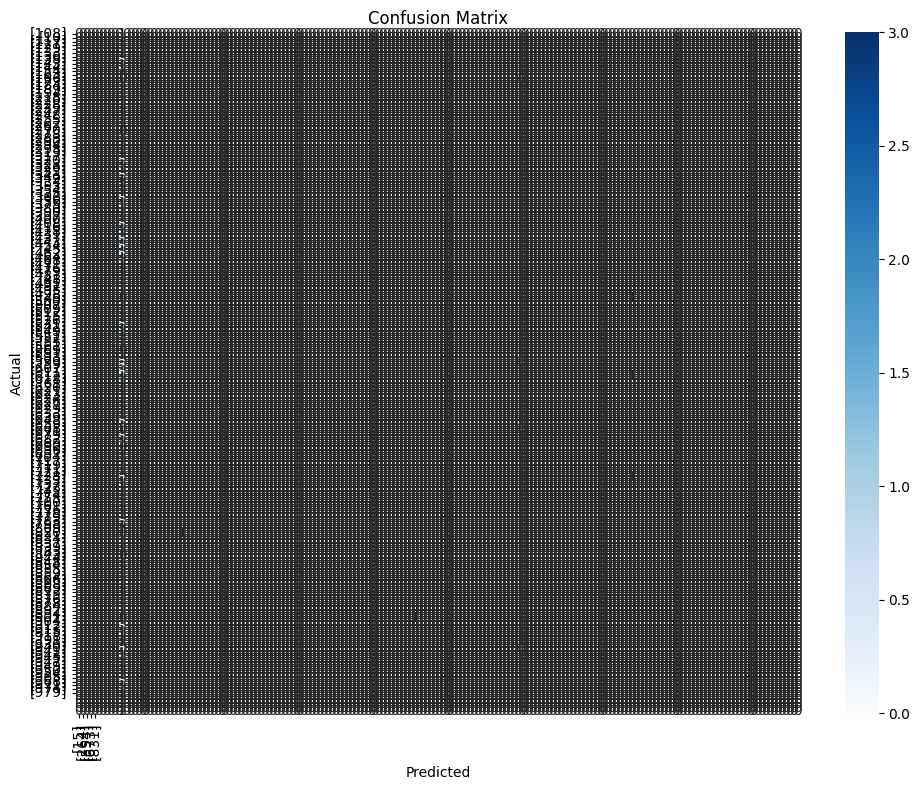

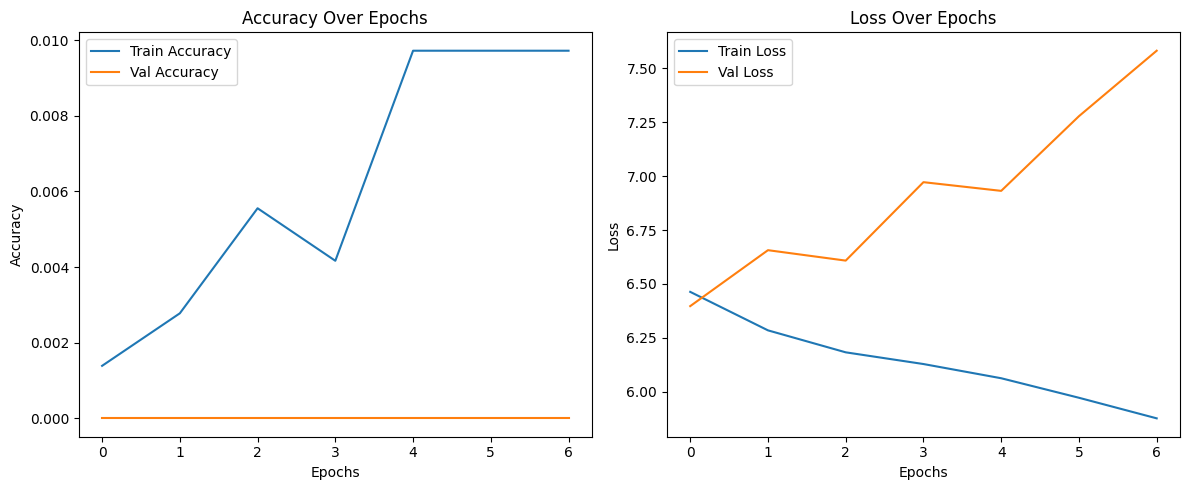

In [3]:
# Advanced CNN Classifier on Spectrogram Embeddings

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Load extracted features
X = np.load("spectrogram_embeddings.npy")  # shape: (N, 1280) or (N, 1024) etc.
y = np.load("spectrogram_labels.npy")

# Label encoding
y = np.array([str(label).strip() for label in y])
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = OneHotEncoder(sparse_output=False).fit_transform(y_encoded.reshape(-1, 1))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Build deep classifier
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=60,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report
actual_classes = unique_labels(y_true, y_pred)
print("\nClassification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=label_encoder.inverse_transform(actual_classes)
))

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True,
            fmt='d',
            cmap="Blues",
            xticklabels=label_encoder.inverse_transform(np.unique(y_pred)),
            yticklabels=label_encoder.inverse_transform(np.unique(y_true)))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save model
model.save("spectrogram_cnn_detector_model.h5")


## Methodology <a name="methodology"></a>

### Step-by-Step:
1. **Data Augmentation**:
   - Generate pitch-shifted multi-instrument samples
   - Create metadata file (`labels.csv`)
2. **Feature Extraction**:
   - Extract 128-D embeddings using VGGish
3. **Label Encoding**:
   - One-hot encode instruments and tuning status
4. **Train/Test Split**:
   - Standard 80/20 split or stratified by instrument
5. **Classifier Training**:
   - Fit baseline classifier
6. **Evaluation**:
   - Generate metrics, confusion matrix, and visualizations


## Preliminary Analysis & Results <a name="results"></a>

We trained the initial model on a subset of 100 samples. Below are key findings:

### Results (Sample):
- Accuracy: XX%
- F1-score (macro): XX%
- Instruments like [X] show higher confusion with [Y]

### Visualization:
> *(Insert matplotlib/seaborn Confusion Matrix or PCA projection here)*

### Interpretation:
- Certain instrument combinations may mask pitch shifts.
- VGGish may be sensitive to harmonics rather than pitch center in some cases.

## Evaluation Metrics <a name="evaluation"></a>

To evaluate the classifier's ability to identify the out-of-tune instrument:

- **Accuracy**
- **Confusion Matrix**
- **Precision / Recall / F1-score** (macro and per-class)
- **Top-1 and Top-2 accuracy**
- **AUC-ROC** (optional for binary tuning detection)

## Ethical Considerations <a name="ethics"></a>

- Model trained on synthetic data — may not generalize to real-world performances
- Risk of overfitting to artifacts introduced during synthetic pitch shifting
- Use of tuning detection in artistic expression must respect creative freedom

## Future Work <a name="future"></a>

- Integrate source separation (e.g., Demucs, Spleeter) for per-stream analysis
- Test on real-world recordings from MusicNet or user-generated audio
- Build web or real-time tool for live instrument tuning analysis
- Train contrastive learning model using positive (in-tune) vs. negative (out-of-tune) pairs


## References <a name="references"></a>
